# Variational Autoencoders

After doing the exercises below, you will be able to:
- Train convolutional VAEs using the reparametrization trick.
- Generete new, unseen data by sampling from the latent space.
- Illustrate interpolation between different images thanks to latent representations.
- Visualize the effect of different weights on the regularization term on the learnt latent space.

**Warning!** If you have issues with the library imports, do not hesitate to use Google Colab instead.

## Library Imports

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## The Fashion MNIST dataset
The following coad loads the MNIST dataset and builds the necessary dataloaders for training.

In [3]:
from torchvision import datasets, transforms
batch_size = 128

# Data loading
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.FashionMNIST(root='../../data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='../../data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)



In [4]:

one_hot_lists = torch.nn.functional.one_hot(torch.arange(0, 10))

one_hot_label = one_hot_lists[9,:]

print(one_hot_label)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])


## 1. Define the VAE class
In this section we will define the VAE class that we will train and use for image generation. We make the choice of training a Convolutional VAE, with the following architecture (once more, we leave the number of hidden dimensions $p$ as a free parameter):
- **The Encoder:** The encoder will consist of the following layers:
    - Convolution layer with 32 filters, a kernel size of 4, stride 2 and padding 1.
    - BatchNorm layer keeping the same number of features
    - ReLu activation
    - Convolution layer with 64 filters, a kernel size of 4, stride 2 and padding 1.
    - BatchNorm layer keeping the same number of features
    - ReLu activation
    - Convolution layer with 128 filters, a kernel size of 3, stride 2 and padding 1.
    - Batchnorm layer keeping the same number of features
    - ReLU layer

- **The Latent Space:** The encoder outputs are converted into the mean vector $\mu$ and logarithm of the variance vector $\log\sigma^2$, via two paraller fully connected layers. We will need to define:
    - A FC layer to map the output of the encoder $E(x)$ to the mean vector $\mu(x)$.
    - A FC layer to map the output of the encoder $E(x)$ to the log-variance vector $\log\sigma^2(x)$.
    - A FC layer to map the sampled hidden stacte $z(x)\sim\mathcal{N}(\mu(x),Diag(\sigma(x)))$ to the decoder input.

- **The Decoder.** The decoder will consist of the following layers:
    - Deconvolution layer with 64 filters, a kernel size of 3, stride 2 and padding 1.
    - BatchNorm layer keeping the same number of features
    - ReLu activation
    - Deconvolution layer with 32 filters, a kernel size of 4, stride 2 and padding 1.
    - BatchNorm layer keeping the same number of features
    - ReLu activation
    - Deconvolution layer with 1 filter, a kernel size of 4, stride 2 and padding 1.
    - Sigmoid layer

In [29]:



class ConditionalConvVAE(nn.Module):
    def __init__(self, latent_dim=10):
        super(ConditionalConvVAE, self).__init__()
        self.latent_dim = latent_dim
        self.nb_labels = 10

        #POUR LA FOIS PROCHAINE
        #Pour l'instant on n'a pas encodé les classes, elles sont encodées comme entiers. Avec des vecteurs ce serait mieux
        
        # Encoder
        self.encoder_first_step = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 14, 14)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 7, 7)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Output: (128, 4, 4)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

            
        self.linear = nn.Linear(128*4*4+self.nb_labels, 128*4*4+self.nb_labels)
        self.ReLU = nn.ReLU()
        # Fully connected layers for mean and log variance
        self.fc_mu = nn.Linear(self.nb_labels+128 * 4 * 4, latent_dim) 
        self.fc_logvar = nn.Linear(self.nb_labels+128 * 4 * 4, latent_dim) 
        self.fc_decode = nn.Linear(latent_dim + self.nb_labels, 128 * 4 * 4) 
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 8, 8)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 16, 16)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # Output: (1, 28, 28)
            nn.Sigmoid()
        )
    
    def encode(self, x, label):
        x = self.encoder_first_step(x) #The convolutive steps
        x = x.view(-1, 128 * 4 * 4)
        
        one_hot_list = torch.nn.functional.one_hot(torch.arange(0, self.nb_labels)).to(device)

        one_hot_label = one_hot_list[label,:]

        if one_hot_label.dim() == 1:  # single integer label
            one_hot_label = one_hot_label.unsqueeze(0).repeat(x.size(0), 1)

        x = torch.cat([x, one_hot_label],  dim=1) #Concatenation

        x = self.linear(x)
        
        #z = x_bis.view(-1, 1 + 128 * 4 * 4) # Flatten the output of the convolutional layers
        z = self.ReLU(x.view(-1, self.nb_labels + 128 * 4 * 4) )
        mu = self.fc_mu(z)
        logvar = self.fc_logvar(z)
        return mu, logvar
    

    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, label):
        one_hot_list = torch.nn.functional.one_hot(torch.arange(0, self.nb_labels)).to(device)
        
        one_hot_label = one_hot_list[label,:]

        if one_hot_label.dim() == 1:  # single integer label
            one_hot_label = one_hot_label.unsqueeze(0).repeat(z.size(0), 1)
        
        z = torch.cat([z, one_hot_label], dim=1)
        x = self.fc_decode(z)
        x = x.view(-1, 128, 4, 4)  # Reshape to (128, 4, 4) for the decoder
        x = self.decoder(x)
        return x

    def forward(self, x, label):
        mu, logvar = self.encode(x,label)
        z = self.sample(mu, logvar)
        return self.decode(z, label), mu, logvar


## 2. Define the loss function

In [30]:
# %load solutions/vae_loss.py
def loss_function(recon_x, x, mu, logvar, beta=1):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD

## 3. Train the VAE
In order to be able to visualize the latent space of the VAE, we will choose a latent dimension equal to 2.

In [31]:
# %load solutions/train_cvae.py
# Hyperparameters
batch_size = 128
latent_dim = 2
learning_rate = 1e-3
epochs = 30
beta = 1

# Initialize the cvae model and the Adam optimizer
cvae = ConditionalConvVAE(latent_dim=latent_dim)
cvae.to(device)
optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)

# Train the model for the given number of epochs
# At the end of each epoch, print the training loss
for epoch in range(1, epochs + 1):
    cvae.train()
    running_loss = 0.0
    for batch_idx, (data, label) in enumerate(train_loader):
        #one_hot_list = torch.nn.functional.one_hot(torch.arange(0, cvae.nb_labels))#.to(device)
        
        #one_hot_label = one_hot_list[label,:]
        
        data = data.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()
        recon_batch, mu, logvar = cvae.forward(data, label)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch}, Training loss: {epoch_loss:.4f}')

Epoch 1, Training loss: 272.2335
Epoch 2, Training loss: 256.6924
Epoch 3, Training loss: 255.1316
Epoch 4, Training loss: 254.2304
Epoch 5, Training loss: 253.5272
Epoch 6, Training loss: 253.0321
Epoch 7, Training loss: 252.5506
Epoch 8, Training loss: 252.2293
Epoch 9, Training loss: 251.8081
Epoch 10, Training loss: 251.4218
Epoch 11, Training loss: 251.0665
Epoch 12, Training loss: 250.8604
Epoch 13, Training loss: 250.5496
Epoch 14, Training loss: 250.2852
Epoch 15, Training loss: 250.0230
Epoch 16, Training loss: 249.8008
Epoch 17, Training loss: 249.6378
Epoch 18, Training loss: 249.3802
Epoch 19, Training loss: 249.1946
Epoch 20, Training loss: 249.0582
Epoch 21, Training loss: 248.8636
Epoch 22, Training loss: 248.7532
Epoch 23, Training loss: 248.5657
Epoch 24, Training loss: 248.4633
Epoch 25, Training loss: 248.2483
Epoch 26, Training loss: 248.1734
Epoch 27, Training loss: 248.0044
Epoch 28, Training loss: 247.8900
Epoch 29, Training loss: 247.8371
Epoch 30, Training loss

## 4. Visualize the results
We first check if the vae model has learnt meaningful features, by plotting a bunch of images from the test set along with their respective reconstructions.

We have already defined a function called `image_comparison` in the previous notebook, that does exactly what we want. We can either copy paste it below, or better yet, create a file in the current folder called `utils.py`, copy-paste the function there, along with all the necessary library imports, and then import the `image_comparison` function in the cell below.

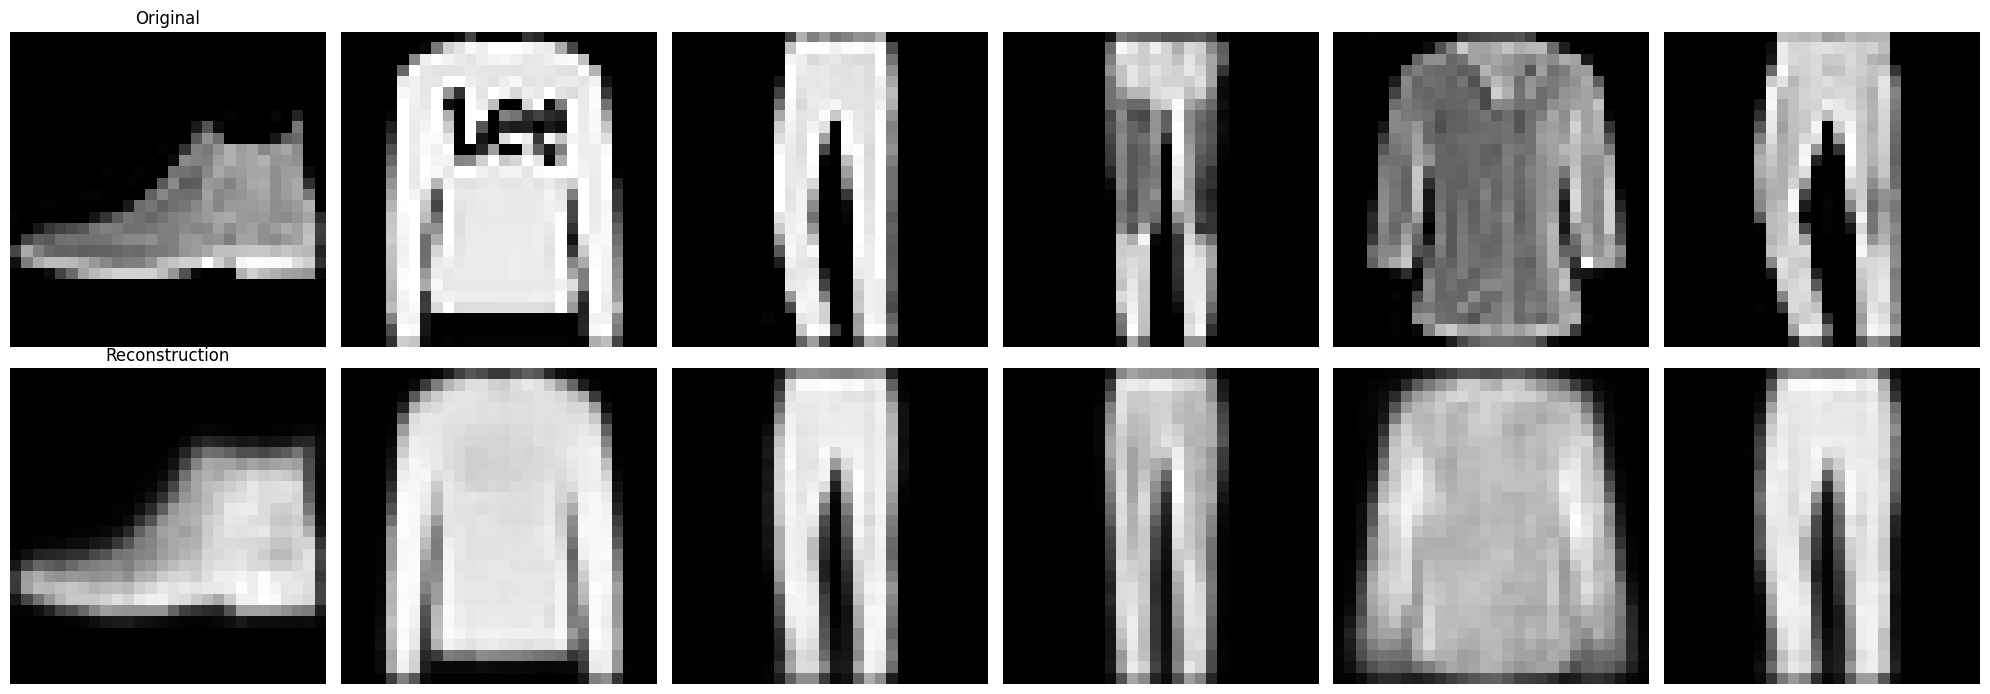

In [59]:
# TODO: Define or import the image_comparison function
def image_comparison(original_images, reconstructions, n_images=6):
    """Plots the original images and its reconstructions for comparison

    Args:
        original_image (torch.Tensor): The original images
        reconstructions (torch.Tensor): Reconstruction of the original images
    """
    fig, ax = plt.subplots(2, n_images, figsize=(20, 7))
    
    for i in range(n_images):
        # Plot original images
        ax[0, i].imshow(original_images[i], cmap='gray')
        ax[0, i].axis('off')
        ax[0, 0].set_title('Original')

        
        # Reconstructed images
        ax[1, i].imshow(reconstructions[i], cmap='gray')
        ax[1, i].axis('off')
        ax[1, 0].set_title('Reconstruction')
    
    plt.tight_layout()
    plt.show()

# Select a batch of images from the test dataset
random_images = next(iter(test_loader))

# Get the reconstructions of the selected images
recons, _, _ = cvae(random_images[0].to(device),random_images[1].to(device))

# Reshape the images for plotting
random_images = random_images[0].cpu().numpy().squeeze()
recons = recons.detach().cpu().numpy().squeeze()

# Plot the original images and their reconstructions
image_comparison(random_images, recons)

## 5. Image generation
The puropose of this section is to generate new images that look like MNIST digits. In order to do so, we follow the steps below:
- Sample $z$ from a $\mathcal{N}(0, I)$ distribution ($I$ being the identity matrix of size $p$).
- Decode $z$ using the decoder of the VAE to generate a new image.

**Question.** Why are we sampling $z$ from a $\mathcal{N}(0,I)$ distribution? What happened to the learnt mean and variance?


We want to generate all classes of images. Fixing a mean and variance would bias the generation towards certain classes. 

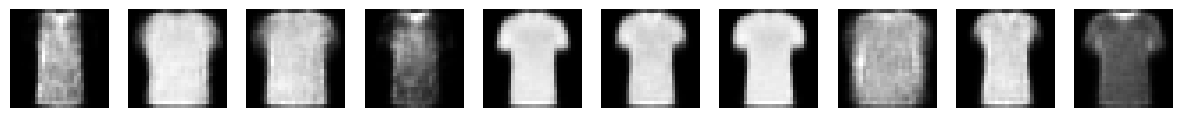

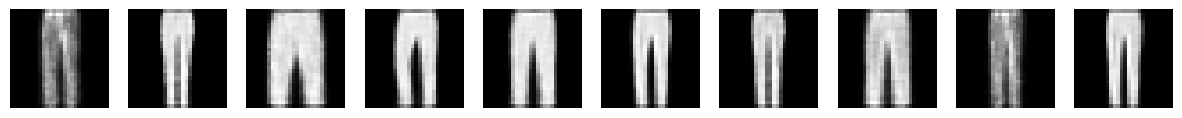

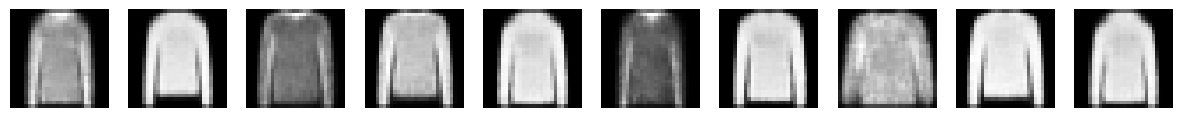

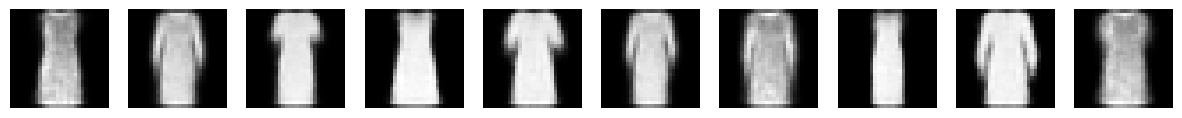

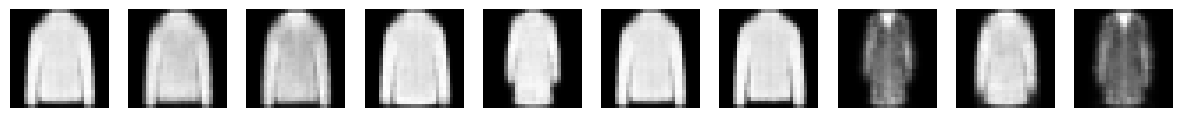

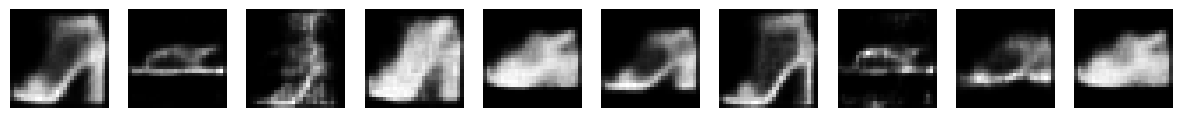

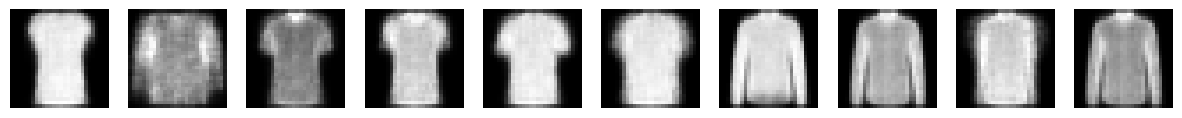

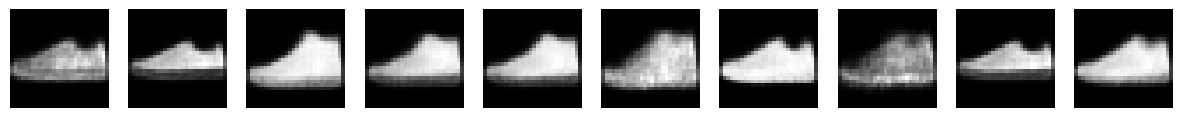

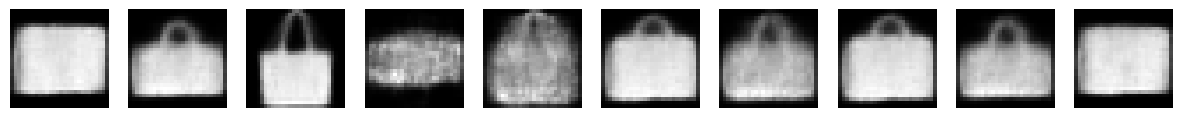

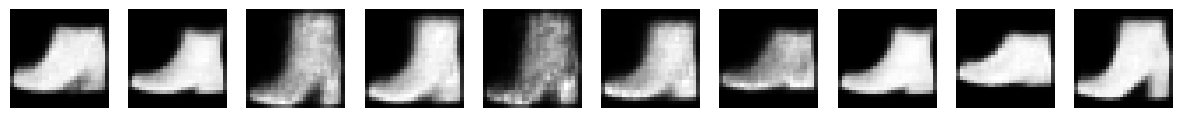

In [63]:
def generate_sample(label, num_samples=10):
    cvae.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)  # Sample latent vectors

        #image_1 = test_dataset[3][0]

        #mu, log_var= cvae.encode(image_1, label = 3)

        #z = cvae.sample(mu=mu, eps=torch.exp(log_var))
        
        samples = cvae.decode(z, label)
        samples = samples.cpu().view(num_samples, 1, 28, 28)  # Reshape

        fig, ax = plt.subplots(1, num_samples, figsize=(15, 2))
        if num_samples == 1:
            ax = [ax]  # Make it indexable

        for i in range(num_samples):
            ax[i].imshow(samples[i].squeeze(0), cmap='gray')
            ax[i].axis('off')
        plt.show()


for i in range(0,10):
    generate_sample(label=i)


**Exercise.** As a follow-up exercise, you can check how if the quality of the generated samples improves when using a VAE trained with a larger hidden dimension.

## 6. Interpolation between Images
The objective of this section is to visualize the difference between the space of latent representations and the (original) pixel space. In order to do so, we will perform *image interpolation*, i.e., we will take two random images $x_2$ and $x_2$ from the test set, and interpolate between them: for a given number of interpolation steps $n$, we have:
- In pixel space, the interpolated image $x_t$ at step $t=0,\dots,n$ is given by taking, for each pixel, the linear interpolation 
$$\frac{n-t}{n}x_1 + \frac{t}{n}x_2.$$
- In the latent space, the interpolated image $x_t$ at step $t=0,\dots,n$ is given by first computing the linear interpolation $z_t$ between the encodings $z_1$ of $x_1$ and $z_2$ of $x_2$, and then decoding $z_t$.

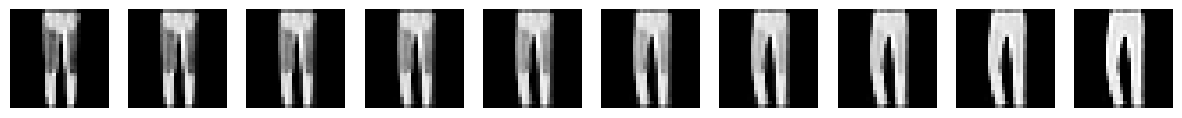

In [64]:

def interpolate_pixel_space(x1, x2, num_steps=10):
    # Ensure the images are on the same device and have the correct shape
    x1 = x1.view(1, 1, 28, 28).to(device)
    x2 = x2.view(1, 1, 28, 28).to(device)

    # Generate interpolation factors between 0 and 1
    t_values = torch.linspace(0, 1, num_steps).to(device).view(-1, 1, 1, 1)

    # Interpolate directly in pixel space
    interpolated_images = x1 * (1 - t_values) + x2 * t_values

    # Move the images to CPU for visualization
    interpolated_images = interpolated_images.cpu().squeeze(1)  # Remove channel dimension if necessary

    # Plot the interpolated images
    fig, ax = plt.subplots(1, num_steps, figsize=(15, 2))
    for i in range(num_steps):
        ax[i].imshow(interpolated_images[i].squeeze(0), cmap='gray')
        ax[i].axis('off')
    plt.show()

x1, x2 = test_dataset[3][0], test_dataset[2][0]
interpolate_pixel_space(x1, x2)

In [ ]:
# TODO: Implement the interpolate_latent_space function
# the function should take two images as input and the numer of interpolation steps
# and plot the interpolated images in a single row

x1, x2 = test_dataset[3][0], test_dataset[2][0]
interpolate_latent_space(x1, x2)

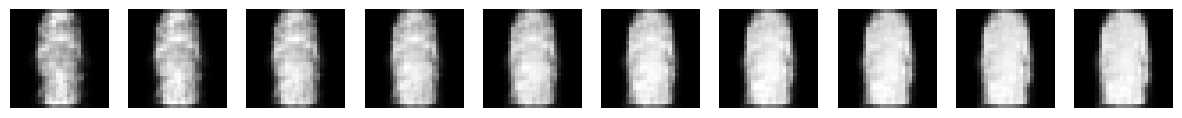

In [66]:
# %load solutions/latent_interp.py
def interpolate_latent_space(x1, x2, label,num_steps=10):
    cvae.eval()
    with torch.no_grad():
        x1, x2 = x1.to(device), x2.to(device)
        mu1, logvar1 = cvae.encode(x1.view(1, 1, 28, 28), label=label)
        mu2, logvar2 = cvae.encode(x2.view(1, 1, 28, 28), label=label)

        z1 = cvae.sample(mu1, logvar1)
        z2 = cvae.sample(mu2, logvar2)

        z = torch.stack([z1 * (1 - t) + z2 * t for t in torch.linspace(0, 1, num_steps)])
        z = z.view(num_steps, -1)  # flatten (num_steps, 1, latent_dim) → (num_steps, latent_dim)

        samples = cvae.decode(z, label=label).cpu()
        samples = samples.view(num_steps, 1, 28, 28)

        fig, ax = plt.subplots(1, num_steps, figsize=(15, 2))
        for i in range(num_steps):
            ax[i].imshow(samples[i].squeeze(0), cmap='gray')
            ax[i].axis('off')
        plt.show()

x1, x2 = test_dataset[3][0], test_dataset[2][0]
interpolate_latent_space(x1, x2,label=2)

**Questions.** 
1. How is the interpolation process any different?
2. Are the first and last images the same for both interpolation processes? Why?

Not exactly because the images are encoded then decoded.

## 7. Visualizing the latent space
The objective of this section is to visualize the latent space and to see how it changes according to which term in the loss function we give more weight to.

In [67]:
# Rewrite loss function to return BCE and KLD separately as well
def loss_function(recon_x, x, mu, logvar, beta=1):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD, BCE, KLD


Training VAE with KL Weight = 1
Epoch 1: Average Loss: 283.2772, BCE: 277.7421, KLD: 5.5351
Epoch 2: Average Loss: 267.1938, BCE: 261.3562, KLD: 5.8377
Epoch 3: Average Loss: 264.6716, BCE: 258.7366, KLD: 5.9350
Epoch 4: Average Loss: 263.2721, BCE: 257.2625, KLD: 6.0096
Epoch 5: Average Loss: 262.1964, BCE: 256.1301, KLD: 6.0663
Epoch 6: Average Loss: 261.3014, BCE: 255.1934, KLD: 6.1080
Epoch 7: Average Loss: 260.4962, BCE: 254.3463, KLD: 6.1499
Epoch 8: Average Loss: 259.8404, BCE: 253.6444, KLD: 6.1959
Epoch 9: Average Loss: 259.4647, BCE: 253.2554, KLD: 6.2093
Epoch 10: Average Loss: 258.9834, BCE: 252.7166, KLD: 6.2668


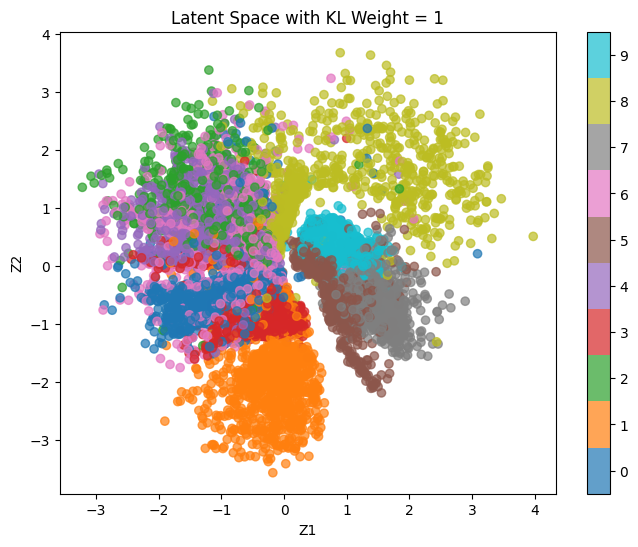


Training VAE with KL Weight = 10
Epoch 1: Average Loss: 323.3378, BCE: 297.1812, KLD: 2.6157
Epoch 2: Average Loss: 306.5938, BCE: 276.5013, KLD: 3.0092
Epoch 3: Average Loss: 304.9064, BCE: 273.9003, KLD: 3.1006
Epoch 4: Average Loss: 303.5339, BCE: 272.1518, KLD: 3.1382
Epoch 5: Average Loss: 302.6756, BCE: 270.7973, KLD: 3.1878
Epoch 6: Average Loss: 302.2220, BCE: 270.0052, KLD: 3.2217
Epoch 7: Average Loss: 301.8346, BCE: 269.3664, KLD: 3.2468
Epoch 8: Average Loss: 301.2525, BCE: 268.5855, KLD: 3.2667
Epoch 9: Average Loss: 300.8524, BCE: 268.0486, KLD: 3.2804
Epoch 10: Average Loss: 300.7042, BCE: 267.7216, KLD: 3.2983


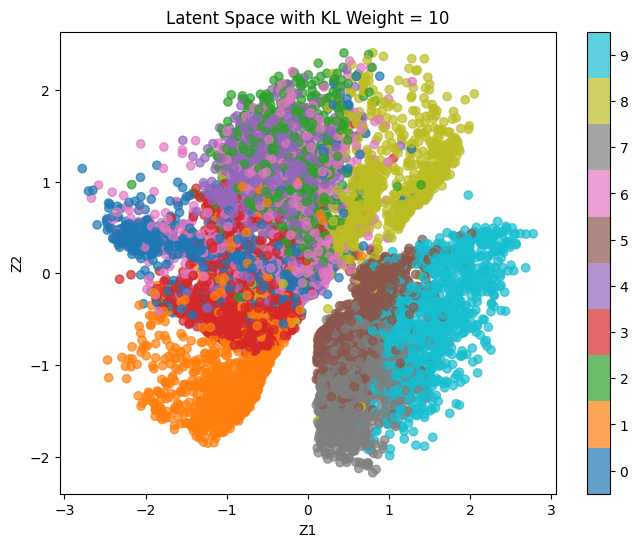


Training VAE with KL Weight = 100
Epoch 1: Average Loss: 400.2541, BCE: 388.5464, KLD: 0.1171
Epoch 2: Average Loss: 384.6738, BCE: 384.6612, KLD: 0.0001
Epoch 3: Average Loss: 384.6075, BCE: 384.5980, KLD: 0.0001
Epoch 4: Average Loss: 384.5610, BCE: 384.5547, KLD: 0.0001
Epoch 5: Average Loss: 384.5677, BCE: 384.5639, KLD: 0.0000
Epoch 6: Average Loss: 384.5171, BCE: 384.5147, KLD: 0.0000
Epoch 7: Average Loss: 384.5377, BCE: 384.5351, KLD: 0.0000
Epoch 8: Average Loss: 384.5127, BCE: 384.5011, KLD: 0.0001
Epoch 9: Average Loss: 384.5076, BCE: 384.4972, KLD: 0.0001
Epoch 10: Average Loss: 384.4954, BCE: 384.4861, KLD: 0.0001


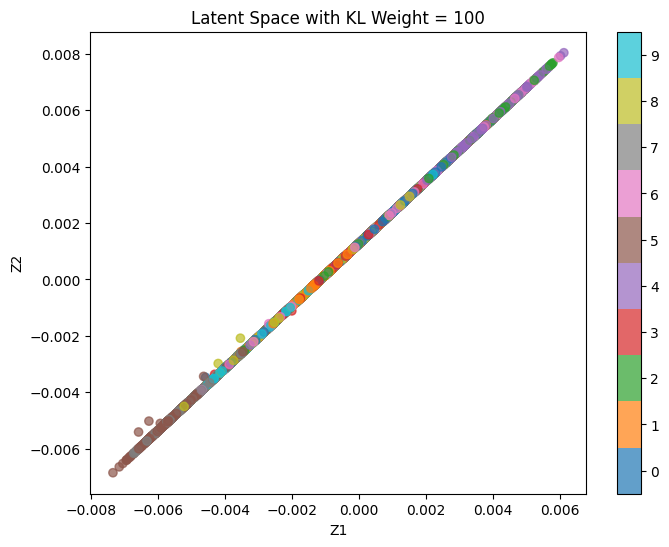

In [70]:
# Hyperparameters
latent_dims = 2
batch_size = 128
num_epochs = 10
learning_rate = 1e-3
kl_weights = [1, 10, 100]  # Different weights for the KL divergence term


label = 0 #very artificial

# Training and plotting function
def train_and_plot(kl_weight):
    model = ConditionalConvVAE(latent_dims).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    model.train()
    train_losses = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        bce_loss = 0
        kld_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            x_recon, mu, logvar = model(data,label)
            loss, bce, kld = loss_function(x_recon, data, mu, logvar, kl_weight)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            bce_loss += bce.item()
            kld_loss += kld.item()
        
        average_loss = epoch_loss / len(train_loader.dataset)
        average_bce = bce_loss / len(train_loader.dataset)
        average_kld = kld_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}: Average Loss: {average_loss:.4f}, BCE: {average_bce:.4f}, KLD: {average_kld:.4f}')
    
    # Plot latent space
    plot_latent_space(model, kl_weight)

# Function to plot latent space
def plot_latent_space(model, kl_weight):
    model.eval()
    with torch.no_grad():
        test_loader = DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)
        data, labels = next(iter(test_loader))
        data = data.to(device)
        mu, logvar = model.encode(data, label=label)
        z = mu  # For visualization, we use the mean
        z = z.cpu().numpy()
        labels = labels.numpy()
        
        plt.figure(figsize=(8,6))
        scatter = plt.scatter(z[:, 0], z[:, 1], c=labels, cmap='tab10', alpha=0.7)
        plt.colorbar(scatter, ticks=range(10))
        plt.clim(-0.5, 9.5)
        plt.title(f'Latent Space with KL Weight = {kl_weight}')
        plt.xlabel('Z1')
        plt.ylabel('Z2')
        plt.show()

# Run training and plotting for different KL weights
for kl_weight in kl_weights:
    print(f'\nTraining VAE with KL Weight = {kl_weight}')
    train_and_plot(kl_weight)


**Question.** 
1. Describe the effect of the KL weight $\beta$ on the latent space.
2. Explain why the described effect happens, and link it with the objective of each of the terms in the loss function.

The higher the beta is, the more we want the mean and variances to be thos of a N(0,1) (The KL divergence measures the difference between a distribution and a N(0,1)). We don't want beta to be 0 because the image generation is made with a N(0,1), and if beta is 0, the cluisters could be too far away from eachother and an image generation could land "in between" clusters and therefore not represent any meaningfull class.